Mounting google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# change to working directory
!cd /content/drive/MyDrive/self_projects/Twitter-Sentiment-Analysis

1. Import libs

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
     

2. Loading datasets

In [ ]:
train = pd.read_csv('datasets/train_tweet.csv')
test = pd.read_csv('datasets/test_tweets.csv')

print("No of train samples: {}, No of features in each sample: {}".format(train.shape[0], train.shape[1]))
print("No of test samples: {}, No of features in each sample: {}".format(test.shape[0], test.shape[1]))

No of train samples: 31962, No of features in each sample: 3
No of test samples: 17197, No of features in each sample: 2


In [ ]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


1 -> +ve tweets, 0 -> -ve tweets


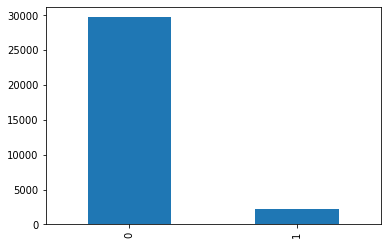

In [ ]:
print("1 -> +ve tweets, 0 -> -ve tweets")
train['label'].value_counts().plot.bar()

3. Data cleaning

In [ ]:
#  checking for null values
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

No null values in the data so data cleaning is not required

- Checking the distribution of tweets in the data

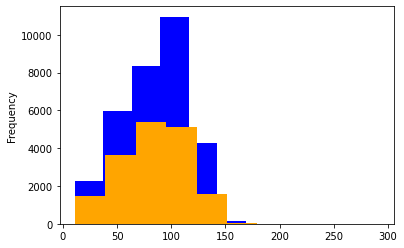

In [ ]:
train['tweet'].str.len().plot.hist(color= "blue")
test['tweet'].str.len().plot.hist(color= "orange")

In [ ]:
# adding the length of the tweet to dataset

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(4)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86


4. Generating word cloud

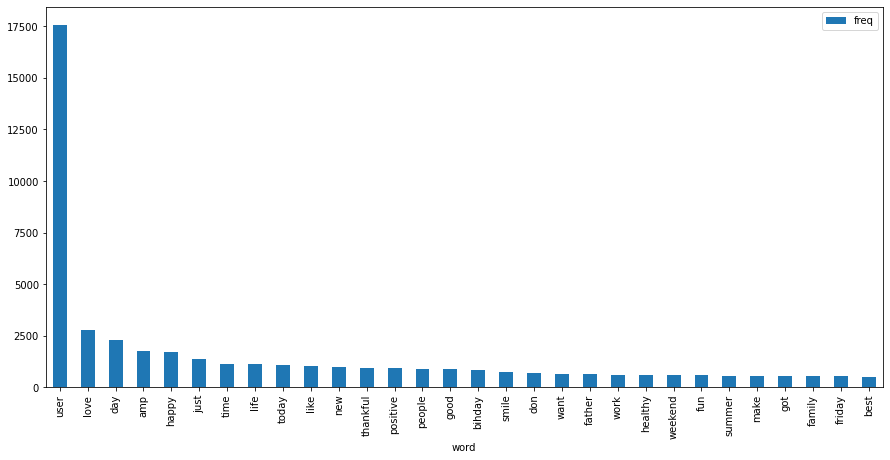

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# word counting
word_counter = CountVectorizer(stop_words = 'english')
words = word_counter.fit_transform(train.tweet)

words_sum = words.sum(axis=0)

# count the freq of diff words in the tweet
words_freq = [(word, words_sum[0, ids]) for word, ids in word_counter.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

freq_df = pd.DataFrame(words_freq, columns=['word', 'freq'])
# visualizing the word freq
freq_df.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7))


Text(0.5, 1.0, 'WordCloud - Vocabulary from tweets')

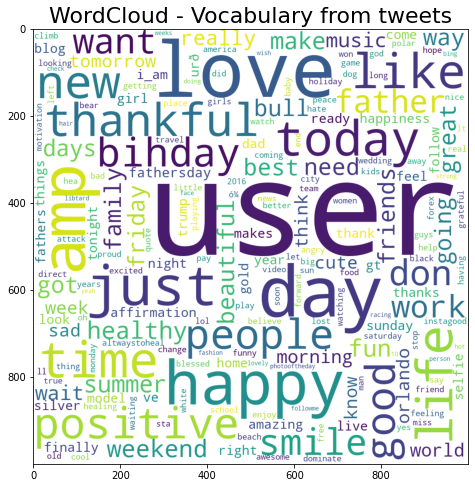

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000)
wordcloud.generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from tweets", fontsize = 22)

5. Processing Tweet Hashtags

In [ ]:
import re

# func to extract hastags from tweets
def hashtag_extractor(df):
    hashtags = []
    
    for tweet in df:
        tags = re.findall(r"#(\w+)", tweet)
        hashtags.append(tags)

    return hashtags

In [ ]:
# extracting hashtags for positive tweets
hashtags_pos = hashtag_extractor(train['tweet'][train['label'] == 0])
# flattening list
hashtags_pos = sum(hashtags_pos, [])

# extracting hashtags for neg tweets
hashtags_neg= hashtag_extractor(train['tweet'][train['label'] == 1])
# flattening list
hashtags_neg = sum(hashtags_neg, [])

- Plotting hashtag freq for positive and negative tweets

In [ ]:
import nltk

pos_htags_freq = nltk.FreqDist(hashtags_pos)
neg_htags_freq = nltk.FreqDist(hashtags_neg)

In [ ]:
pos_htags_freq

FreqDist({'love': 1531, 'positive': 874, 'healthy': 570, 'smile': 548, 'thankful': 491, 'fun': 434, 'life': 405, 'summer': 367, 'model': 364, 'affirmation': 363, ...})

#### Pos Hashtags

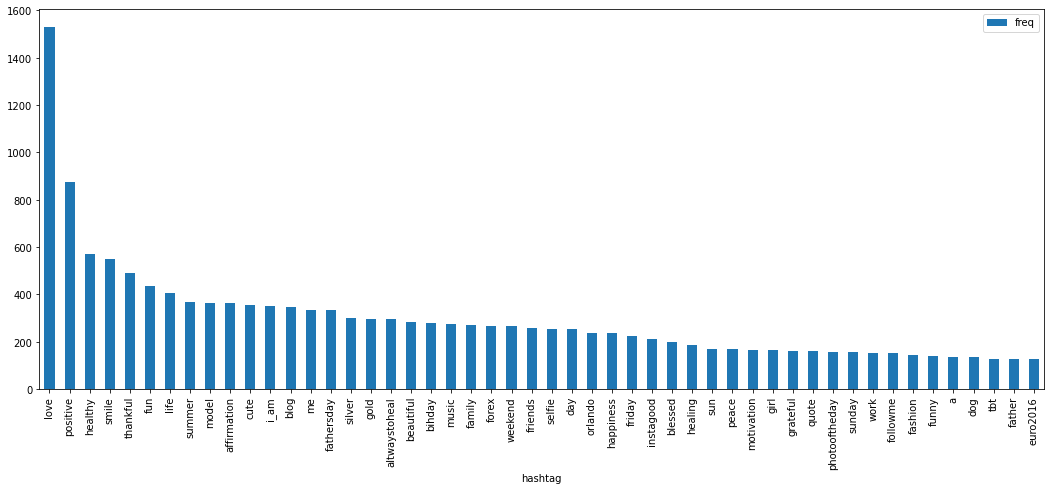

In [ ]:
pd.DataFrame({'hashtag': pos_htags_freq.keys(), 'freq':pos_htags_freq.values()}).sort_values(by = 'freq', ascending = False).head(50).plot(x='hashtag', y='freq', kind='bar', figsize=(18, 7))

### Neg Hashtags

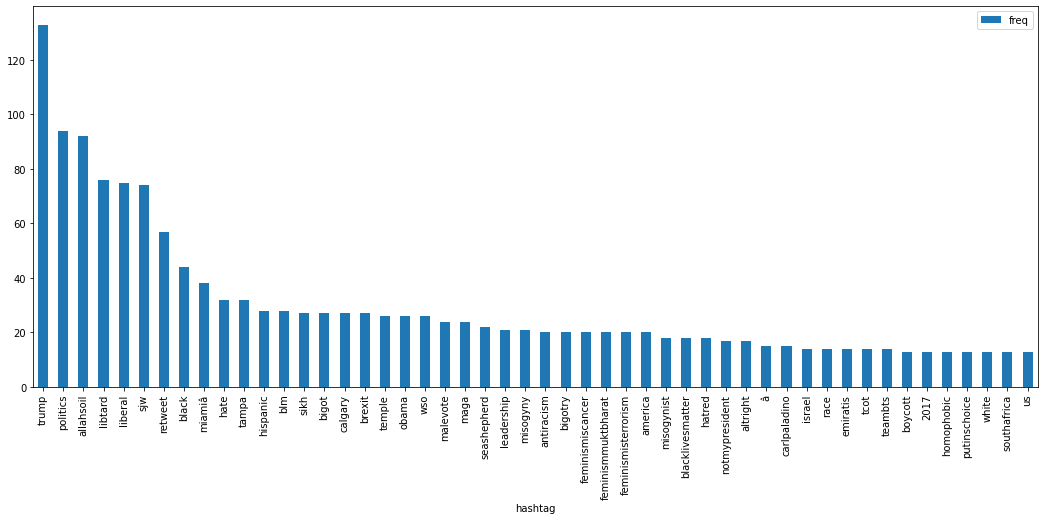

In [ ]:
pd.DataFrame({'hashtag': neg_htags_freq.keys(), 'freq':neg_htags_freq.values()}).sort_values(by = 'freq', ascending = False).head(50).plot(x='hashtag', y='freq', kind='bar', figsize=(18, 7))

### Using different models

1. Word2Vec

In [ ]:
import gensim

In [ ]:
# tokenizing the words present in the training set
tweet_words = train['tweet'].apply(lambda x: x.split())

# creating a word to vector model
word_2_vec_model = gensim.models.Word2Vec(
            tweet_words,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

word_2_vec_model.train(tweet_words, total_examples= len(train['tweet']), epochs=20)

In [ ]:
word_2_vec_model.wv.most_similar(positive = "dinner")

[('spaghetti', 0.6559115052223206),
 ('sister!!', 0.608302116394043),
 ('#boardgames', 0.6045278310775757),
 ('podium', 0.6005160808563232),
 ('#demoday', 0.5932399034500122),
 ('#prosecco', 0.5929815173149109),
 ('toes', 0.590753436088562),
 ('galway', 0.5899454355239868),
 ('shopping!', 0.5892077684402466),
 ('chills', 0.5856996774673462)]

In [ ]:
word_2_vec_model.wv.most_similar(negative = "hate")

[('#apple', -0.019769754260778427),
 ('#fundraising', -0.030572539195418358),
 ('#yay', -0.030781704932451248),
 ('â\x80¦', -0.04117022454738617),
 ('#gym', -0.05252702161669731),
 ('currently', -0.05528847873210907),
 ('#hype', -0.05566088855266571),
 ('#games', -0.06764215230941772),
 ('#unicorn', -0.06877964735031128),
 ('#cycling', -0.07031792402267456)]